In [1]:
import pydicom
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot, cm
import cv2 
from sklearn.preprocessing import LabelEncoder

In [2]:
#Load the Class info csv file and explore data.

class_dt = pd.read_csv("F:/Nag/Olympus/Captone Project/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")
class_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
class        30227 non-null object
dtypes: object(2)
memory usage: 472.4+ KB


In [3]:
print(class_dt.isnull().sum())

patientId    0
class        0
dtype: int64


One Patient can problem in 1 lung or 2 lungs. Count each patient only once.

In [4]:
unique_data = class_dt.drop_duplicates()

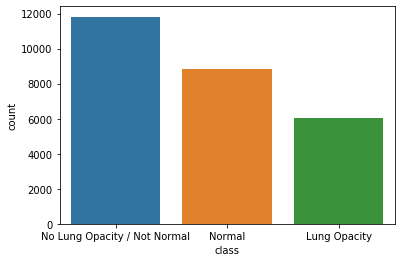

In [5]:
sns.countplot('class', data = unique_data)

In [6]:
print('Number of unique patientids: ' , class_dt['patientId'].nunique())

Number of unique patientids:  26684


In [7]:
#Load the training labels from train labels csv and explore

masks_dt = pd.read_csv("F:/Nag/Olympus/Captone Project/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
masks_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


Counting each patient only one time, as there could be 1 or 2 rows for each patient.

In [8]:
unique_targets = masks_dt.filter(['patientId','Target'], axis =1)
print(unique_targets.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
Target       30227 non-null int64
dtypes: int64(1), object(1)
memory usage: 472.4+ KB
None


In [9]:
unique_targets = unique_targets.drop_duplicates()
print(unique_targets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
patientId    26684 non-null object
Target       26684 non-null int64
dtypes: int64(1), object(1)
memory usage: 625.4+ KB
None


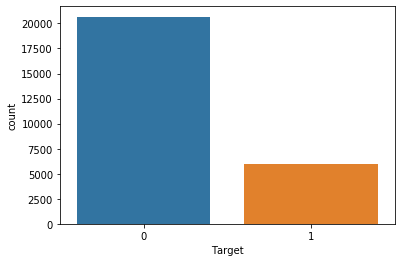

In [10]:
sns.countplot('Target', data = unique_targets)

In [11]:
masks_dt.fillna(0, inplace=True)

In [12]:
masks_dt['image_name'] = masks_dt.patientId + '.dcm'

masks_dt = masks_dt.rename(columns = {'x': 'xmin', 'y': 'ymin'})

masks_dt['xmax'] = masks_dt.xmin + masks_dt.width
masks_dt['ymax'] = masks_dt.ymin + masks_dt.height

#Set the closs in train label to class from class info.
masks_dt['class'] = class_dt['class']

masks_dt = masks_dt[['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class']]   

In [13]:
masks_dt.head()

,image_name,xmin,ymin,xmax,ymax,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0.0,0.0,0.0,0.0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0.0,0.0,0.0,0.0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0.0,0.0,0.0,0.0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0.0,0.0,0.0,0.0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,264.0,152.0,477.0,531.0,Lung Opacity


In [14]:
PathDicom = "F:/Nag/Olympus/Captone Project/rsna-pneumonia-detection-challenge/stage_2_train_images/"

In [15]:
#Encode the class names
le = LabelEncoder()
label_encoders = le.fit(masks_dt['class'].unique())

print(label_encoders.classes_)

masks_dt['class'] = label_encoders.transform(masks_dt['class'] )

['Lung Opacity' 'No Lung Opacity / Not Normal' 'Normal']


In [16]:
#Filtering for samples that have problem in both lungs.
issue_counts = masks_dt['image_name'].value_counts()
filtered_data = (masks_dt[masks_dt['image_name'].isin(issue_counts[issue_counts >= 2].index)])

sample_class_0 = filtered_data[filtered_data['class'] ==0]
filename = sample_class_0.get_value(sample_class_0.index[0],'image_name')
masks_sample = masks_dt[masks_dt['image_name'] == filename]

print(masks_sample)


                                 image_name   xmin   ymin   xmax   ymax  class
4  00436515-870c-4b36-a041-de91049b9ab4.dcm  264.0  152.0  477.0  531.0      0
5  00436515-870c-4b36-a041-de91049b9ab4.dcm  562.0  152.0  818.0  605.0      0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


This sample is a positive pneumonia case with bounding box details available for both left and right lungs.

In [17]:
ds = pydicom.read_file(PathDicom + filename)

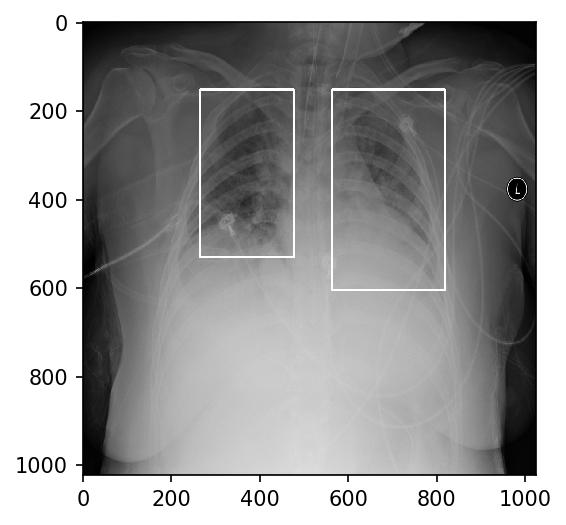

In [18]:

output_image = cv2.resize(ds.pixel_array,(1024,1024))

#add bounding boxes
cv2.rectangle(output_image, (int(masks_dt['xmin'][4]), int(masks_dt['ymin'][4])), (int(masks_dt['xmax'][4]), int(masks_dt['ymax'][4])),(255,0,0), 3)
cv2.rectangle(output_image, (int(masks_dt['xmin'][5]), int(masks_dt['ymin'][5])), (int(masks_dt['xmax'][5]), int(masks_dt['ymax'][5])), (255,0,0) ,3)

#Display the sample image with bounding boxes
pyplot.figure(dpi=150)
pyplot.imshow(output_image, cmap = cm.gray)

This sample is a positive pneumioa case with bounding box for only 1 lung.

In [19]:
#Filtering for samples that have problem only in 1 lung.
filtered_data = (masks_dt[masks_dt['image_name'].isin(issue_counts[issue_counts == 1].index)])

sample_class_0_1 = filtered_data[filtered_data['class'] ==0]
filename = sample_class_0_1.get_value(sample_class_0_1.index[0],'image_name')
masks_sample = masks_dt[masks_dt['image_name'] == filename]

print(masks_sample)

                                  image_name   xmin   ymin   xmax   ymax  \
22  0100515c-5204-4f31-98e0-f35e4b00004a.dcm  703.0  416.0  787.0  493.0   

    class  
22      0  


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [20]:
ds = pydicom.read_file(PathDicom + filename)

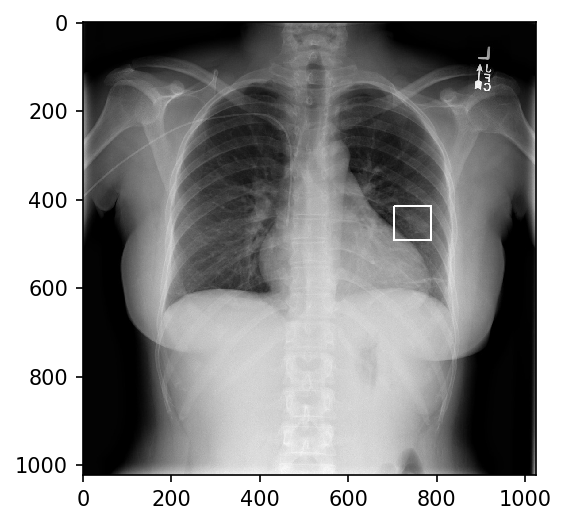

In [21]:

output_image = cv2.resize(ds.pixel_array,(1024,1024))

#add 1 bounding box
cv2.rectangle(output_image, (int(masks_dt['xmin'][22]), int(masks_dt['ymin'][22])), (int(masks_dt['xmax'][22]), int(masks_dt['ymax'][22])),(255,0,0), 3)

#Display the sample image with bounding box
pyplot.figure(dpi=150)
pyplot.imshow(output_image, cmap = cm.gray)

In [22]:
sample_class_1 = masks_dt[masks_dt['class'] ==1]
filename = sample_class_1.get_value(sample_class_1.index[0],'image_name')
masks_sample = masks_dt[masks_dt['image_name'] == filename]

print(masks_sample)

                                 image_name  xmin  ymin  xmax  ymax  class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm   0.0   0.0   0.0   0.0      1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


This is a sample X-Ray of a patient who is not normal but does not have pneumonia.

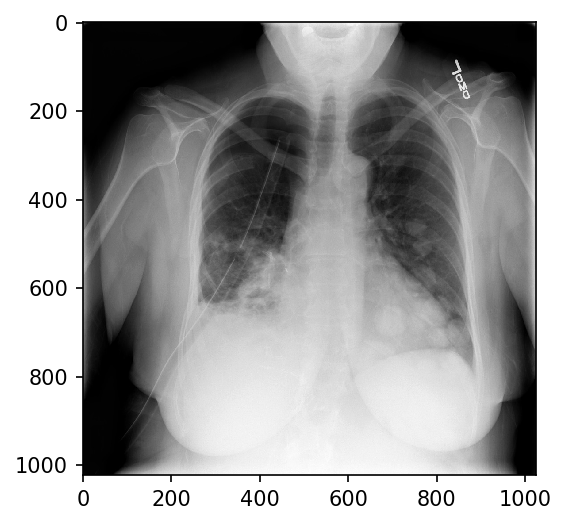

In [23]:
ds = pydicom.read_file(PathDicom + filename)
output_image = cv2.resize(ds.pixel_array,(1024,1024))
pyplot.figure(dpi=150)
pyplot.imshow(output_image, cmap = cm.gray)

In [24]:
sample_class_2 = masks_dt[masks_dt['class'] ==2]
filename = sample_class_2.get_value(sample_class_2.index[0],'image_name')
masks_sample = masks_dt[masks_dt['image_name'] == filename]
print(masks_sample)

                                 image_name  xmin  ymin  xmax  ymax  class
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm   0.0   0.0   0.0   0.0      2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


This is sample X-ray of the patient that is normal.

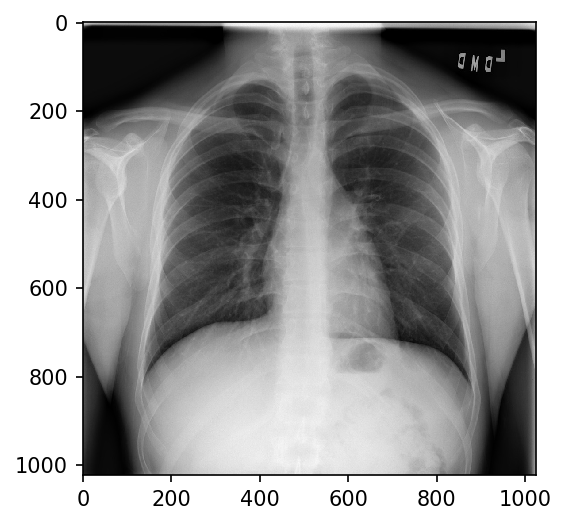

In [25]:
ds = pydicom.read_file(PathDicom + filename)
output_image = cv2.resize(ds.pixel_array,(1024,1024))
pyplot.figure(dpi=150)
pyplot.imshow(output_image, cmap = cm.gray)